# Testing TF Models in Tx-2

# Model benchmarker mobilenet_v1_1.0_224

In [16]:
# Run setup or download and extract the below models

# wget -nc http://download.tensorflow.org/models/mobilenet_v1_2018_08_02/mobilenet_v1_1.0_224.tgz
# tar -xvf mobilenet_v1_1.0_224.tgz


In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import json
import time

In [2]:
import cv2

In [221]:
## Not used code
## Path to frozen graph is added directly

# MODEL_NAME = 'mobilenet_v1_1.0_224'

# MODEL_FILE = MODEL_NAME + '.tgz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/mobilenet_v1_2018_08_02/'

# info='Time taken to download Model:'

# start_time=time.time()

# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# end_time=time.time()
# time_taken=end_time-start_time
# print(info,time_taken)


In [4]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
# Graph = Tests/data/mobilenet_v1_1.0_224
# Extracted graph path

PATH_TO_FROZEN_GRAPH = '../data/mobilenet_v2_1.4_224/mobilenet_v2_1.4_224_frozen.pb'

In [5]:

info='Time taken to load Model into memory:'
start_time=time.time()

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
end_time=time.time()
time_taken=end_time-start_time
print(info,time_taken)

Time taken to load Model into memory: 0.17618012428283691


In [6]:
# Load the labels

#Load preprocessing data
mean = 128 
std = 1.0/128.0 

#Load categories
categories = []
with open('../data/' + 'categories.txt', 'r') as f:
    for line in f:
        cat = line.split('\n')[0]
        if cat != 'classes':
            categories.append(cat)
    f.close()
    print('Number of categories:', len(categories))

Number of categories: 1001


In [7]:
#categories

In [60]:
# Load image size
with open('../data/' + 'inputsize.txt', 'r') as f:
    reqsize = int(f.readline().split('\n')[0])
print(reqsize)

224


# Preparing Input

In [72]:
#image_filename = '../data/' + 'Tiger.jpg'

image_filename = '../data/' + 'image1.jpg'

img = cv2.imread(image_filename)#.astype(numpy.float32)

print(img.shape)

(636, 1024, 3)


In [73]:
# Resizing
# dx,dy,dz= img.shape
# delta=float(abs(dy-dx))
# if dx > dy: #crop the x dimension
#     img=img[int(0.5*delta):dx-int(0.5*delta),0:dy]
# else:
#     img=img[0:dx,int(0.5*delta):dy-int(0.5*delta)]


img = cv2.resize(img, (reqsize, reqsize))

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#for i in range(3):
#    img[:,:,i] = (img[:,:,i] - mean) * std


In [74]:
#img = cv2.resize(img, (reqsize, reqsize))
img = img.astype(float)
print(img.shape)

(224, 224, 3)


In [75]:
def preprocess_input(x):
    x /= 255.0
    x -= 0.5
    x *= 2.0
    return x

In [76]:
img = preprocess_input(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


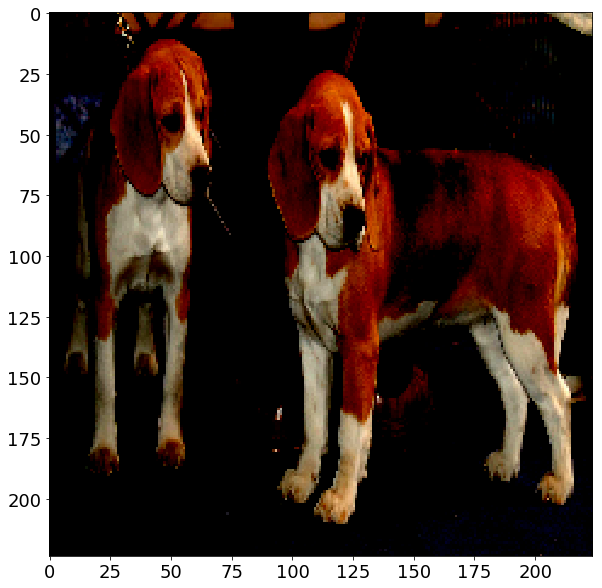

In [77]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))

plt.imshow(img)
plt.show()

# Running inference using TF

In [78]:
sess=tf.Session(graph=detection_graph)

In [79]:
def run_inference(key_name,image, graph):
    
    #model output layer name
    ops = detection_graph.get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    #print(all_tensor_names)
    tensor_dict = {}
    for key in [key_name]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)
            
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image_tensor = graph.get_tensor_by_name('input:0')
    # Run inference
    info='Time taken to run inference:'
    start_time=time.time()

    output_dict = sess.run(tensor_dict,
                          feed_dict={image_tensor: image})
    
    end_time=time.time()
    time_taken=end_time-start_time
    print(info,time_taken)

    #print(output_dict)
    top_inds = output_dict[key_name][0].argsort()[::-1][:10]
    print(output_dict[key_name][0].shape)
    result=[]
    for i in range(10):
        result.append([top_inds[i], categories[top_inds[i]], output_dict[key_name][0][top_inds[i]]])
    return result

In [80]:
# key_name='MobilenetV1/Predictions/Softmax'
# run_inference(key_name,img,detection_graph)

#Gives the same results as Reshape_1 output layer

In [81]:
key_name='MobilenetV2/Predictions/Reshape_1'
result=run_inference(key_name,img,detection_graph)

Time taken to run inference: 0.25406408309936523
(1001,)


In [82]:
result

[[163, 'beagle', 0.27662575],
 [168, 'English foxhound', 0.07908593],
 [248, 'Saint Bernard, St Bernard', 0.06638973],
 [167, 'Walker hound, Walker foxhound', 0.020111587],
 [164, 'bloodhound, sleuthhound', 0.013369867],
 [162, 'basset, basset hound', 0.013369682],
 [254, 'basenji', 0.0051595317],
 [221, 'Sussex spaniel', 0.004790657],
 [100, 'goose', 0.003511218],
 [435, 'bath towel', 0.0034573206]]

# benchmarking the TF model by running inference 100 times

In [111]:
# Settings: run_inference_b1
# 1. Model is in memory.
# 2. Input is well prepared and in memory
# 3. Calculating time just to run the inference.

In [139]:
def run_inference_b1(key_name,image, graph,no_of_run):
    
    #model output layer name
    ops = detection_graph.get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    #print(all_tensor_names)
    tensor_dict = {}
    for key in [key_name]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)
            
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image_tensor = graph.get_tensor_by_name('input:0')
    # Run inference
    info='Time taken to run inference: run_inference_b1:'+str(no_of_run)+' Times: '
    start_time=time.time()
    
    for i in range(no_of_run):
        output_dict = sess.run(tensor_dict,
                          feed_dict={image_tensor: image})
    
    end_time=time.time()
    time_taken=end_time-start_time
    print(info,time_taken)

    #print(output_dict)
    top_inds = output_dict[key_name][0].argsort()[::-1][:5]
    
    result=[]
    for i in range(5):
        result.append([top_inds[i], categories[top_inds[i]], output_dict[key_name][0][top_inds[i]]])
    return result, time_taken
 

In [140]:
key_name='MobilenetV1/Predictions/Reshape_1'
result,time_taken=run_inference_b1(key_name,img,detection_graph,10000)

Time taken to run inference: run_inference_b1:10000 Times:  35.70415997505188


In [145]:
print('Time Taken is:',time_taken)
print(result)

Time Taken is: 35.70415997505188
[[905, 'window screen', 0.5261927], [972, 'bubble', 0.08278581], [917, 'web site, website, internet site, site', 0.04623654], [531, 'digital clock', 0.036774535], [967, 'red wine', 0.034109596]]


In [144]:
# With img all pointint to '0'

img2 = np.zeros((224, 224,3))

key_name='MobilenetV1/Predictions/Reshape_1'
result2,time_taken2=run_inference_b1(key_name,img2,detection_graph,10000)

Time taken to run inference: run_inference_b1:10000 Times:  37.0537474155426


In [146]:
print('Time Taken is:',time_taken2)
print(result2)

Time Taken is: 37.0537474155426
[[112, 'nematode, nematode worm, roundworm', 0.049591947], [645, 'matchstick', 0.026461348], [535, 'dishwasher, dish washer, dishwashing machine', 0.0152283], [819, 'spotlight, spot', 0.013619817], [684, 'oboe, hautboy, hautbois', 0.01164585]]


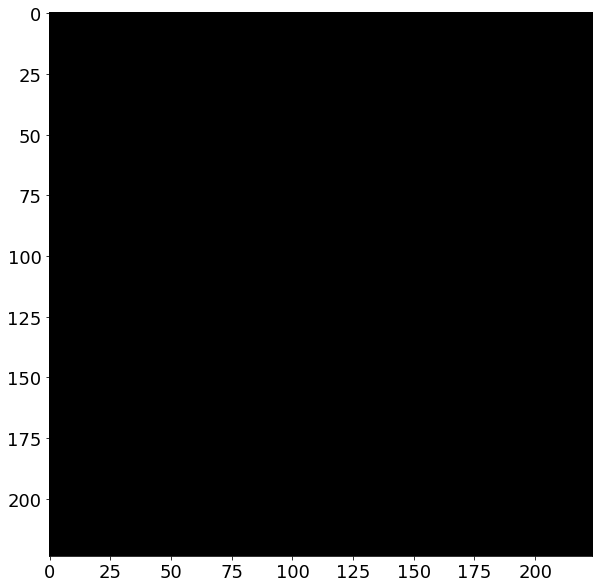

In [149]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))

plt.imshow(img2)
plt.show()

In [150]:
# With img all pointint to '1'

img3 = np.ones((224, 224,3))

key_name='MobilenetV1/Predictions/Reshape_1'
result3,time_taken3=run_inference_b1(key_name,img3,detection_graph,10000)

Time taken to run inference: run_inference_b1:10000 Times:  37.23666548728943


In [151]:
print('Time Taken is:',time_taken3)
print(result3)

Time Taken is: 37.23666548728943
[[513, 'corkscrew, bottle screw', 0.014487103], [550, 'envelope', 0.01196879], [552, 'face powder', 0.011554672], [624, 'letter opener, paper knife, paperknife', 0.0104372185], [903, 'whistle', 0.010196953]]


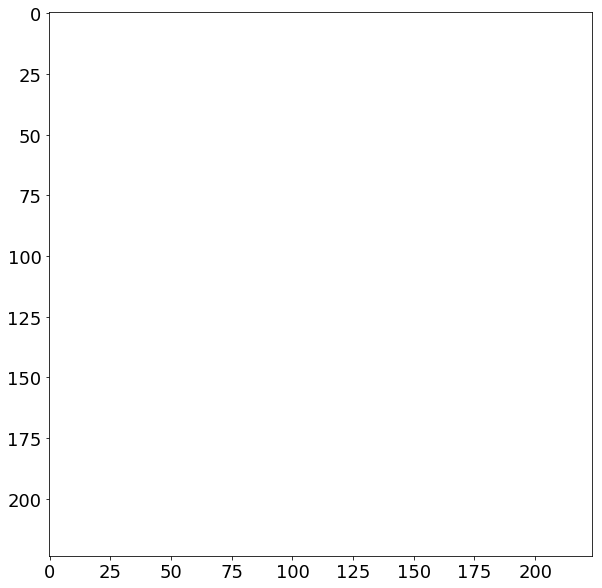

In [152]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))

plt.imshow(img3)
plt.show()